# LSGAN(Least SquaresGAN)

## GAN
$$L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z))]$$

$$L_G^{GAN} = E[log(D(G(z)))]$$

## LSGAN
$$L_D^{LSGAN} = E[(D(x) - 1)^2] + E[D(G(z))^2]$$

$$L_G^{LSGAN} = E[(D(G(z)) - 1)^2$$

## LSGAN의 Loss function
1. p(x)와 p(z)간의 거리를 KLD가 아닌 거리 측정 지표로 Least Square를 사용함. 

$$min_D V_{LSGAN}(D) = \frac{1}{2} E_{x \sim P_{data}(x)} \Big[(D(x) - b)^2 \big] + \frac{1}{2} E_{z \sim P_z(z)} \big[ (D(G(z)) - a)^2 \big]$$

$$min_G V_{LSGAN} = \frac{1}{2} E_{z \sim P_z(z)} \big[ (D(G(z)) - c)^2 \big]$$

Discriminator는 진짜 데이터 $x$를 받았을 때 $b$를 출력하도록, 가짜 데이터 $G(z)$인 경우 $a$가 되도록 학습하게 됨. **$G$는 $D$가 가짜 데이터를 받았을 때 $c$를 출력하도록 유도함**.

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


## 2. Setting hyperparameters

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
z_dim = 62
sample_num = 64
beta1 = 0.5
beta2 = 0.999

result_dir = './save_results/MNIST/LSGAN'
model_dir = './save_models/MNIST/LSGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")

print(data_X.size())
print(data_Y.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([70000, 10])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim # 1
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        return x

## utils

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Loss func
- MSE Loss

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

sample_z = torch.randn((batch_size, z_dim), requires_grad=False)

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

criterion = nn.MSELoss()

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

## 6. Load models

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/lsgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/lsgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



In [10]:
print(G)
print(D)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)
Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

## 7. Train

$$L_D^{LSGAN} = E[(D(x) - 1)^2] + E[D(G(z))^2]$$

$$L_G^{LSGAN} = E[(D(G(z)) - 1)^2$$

In [11]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels =  real_labels.cuda()
    fake_labels = fake_labels.cuda()

In [12]:
D.train()
print('training start!!')
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    G.train()
    epoch_start_time = time.time()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]

        z = torch.rand((batch_size, z_dim))

        if USE_CUDA:
            images = images.cuda() 
            z = z.cuda()
            
        #============= Train the discriminator =============#
        # update D network
        d_optimizer.zero_grad()
        
        d_real = D(images)
        d_loss_real = criterion(d_real, real_labels)
        real_score = d_real
        
        fake_images = G(z)
        d_fake = D(fake_images)
        d_loss_fake = criterion(d_fake, fake_labels)
            
        d_loss = d_loss_real + d_loss_fake
        
        fake_score = d_fake
        train_hist['d_loss'].append(d_loss.item())
        
        d_loss.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # update G network
        g_optimizer.zero_grad()

        fake_images = G(z)
        d_fake = D(fake_images)
        g_loss = criterion(d_fake, real_labels)
        train_hist['g_loss'].append(g_loss.item())

        g_loss.backward()
        g_optimizer.step()

        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], d_loss: %.4f, g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
                  %(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, 
                    d_loss.item(), g_loss.item(), real_score.data.mean(), fake_score.data.mean()))
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # Save sample images
    samples = G(sample_z)
    generated_sample = samples.view(images.size(0), 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/lsgan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/lsgan_discriminator.pkl')

loss_plot(train_hist, result_dir, 'LSGAN')

training start!!
Epoch [1/30], Step [100/1093], d_loss: 0.3718, g_loss: 0.3595, D(x): 0.57, D(G(z)): 0.42
Epoch [1/30], Step [200/1093], d_loss: 0.2732, g_loss: 0.4539, D(x): 0.64, D(G(z)): 0.34
Epoch [1/30], Step [300/1093], d_loss: 0.1816, g_loss: 0.5317, D(x): 0.71, D(G(z)): 0.29
Epoch [1/30], Step [400/1093], d_loss: 0.1336, g_loss: 0.5901, D(x): 0.77, D(G(z)): 0.25
Epoch [1/30], Step [500/1093], d_loss: 0.1328, g_loss: 0.6244, D(x): 0.78, D(G(z)): 0.23
Epoch [1/30], Step [600/1093], d_loss: 0.1327, g_loss: 0.6154, D(x): 0.79, D(G(z)): 0.24
Epoch [1/30], Step [700/1093], d_loss: 0.1811, g_loss: 0.6021, D(x): 0.75, D(G(z)): 0.30
Epoch [1/30], Step [800/1093], d_loss: 0.2620, g_loss: 0.4304, D(x): 0.63, D(G(z)): 0.31
Epoch [1/30], Step [900/1093], d_loss: 0.3600, g_loss: 0.4852, D(x): 0.61, D(G(z)): 0.37
Epoch [1/30], Step [1000/1093], d_loss: 0.4313, g_loss: 0.4973, D(x): 0.55, D(G(z)): 0.40
Epoch [2/30], Step [100/1093], d_loss: 0.3371, g_loss: 0.4088, D(x): 0.61, D(G(z)): 0.39
Epo

Epoch [10/30], Step [300/1093], d_loss: 0.1632, g_loss: 0.7143, D(x): 0.78, D(G(z)): 0.25
Epoch [10/30], Step [400/1093], d_loss: 0.2168, g_loss: 0.4580, D(x): 0.68, D(G(z)): 0.25
Epoch [10/30], Step [500/1093], d_loss: 0.1695, g_loss: 0.6751, D(x): 0.73, D(G(z)): 0.19
Epoch [10/30], Step [600/1093], d_loss: 0.2461, g_loss: 0.6536, D(x): 0.71, D(G(z)): 0.31
Epoch [10/30], Step [700/1093], d_loss: 0.1506, g_loss: 0.7156, D(x): 0.82, D(G(z)): 0.26
Epoch [10/30], Step [800/1093], d_loss: 0.2513, g_loss: 0.4690, D(x): 0.61, D(G(z)): 0.21
Epoch [10/30], Step [900/1093], d_loss: 0.1834, g_loss: 0.7718, D(x): 0.79, D(G(z)): 0.30
Epoch [10/30], Step [1000/1093], d_loss: 0.2514, g_loss: 0.7981, D(x): 0.70, D(G(z)): 0.21
Epoch [11/30], Step [100/1093], d_loss: 0.2435, g_loss: 0.5177, D(x): 0.60, D(G(z)): 0.15
Epoch [11/30], Step [200/1093], d_loss: 0.1691, g_loss: 0.7542, D(x): 0.85, D(G(z)): 0.29
Epoch [11/30], Step [300/1093], d_loss: 0.1808, g_loss: 0.7974, D(x): 0.87, D(G(z)): 0.35
Epoch [11

Epoch [19/30], Step [400/1093], d_loss: 0.1414, g_loss: 0.7071, D(x): 0.83, D(G(z)): 0.23
Epoch [19/30], Step [500/1093], d_loss: 0.1516, g_loss: 0.6327, D(x): 0.73, D(G(z)): 0.14
Epoch [19/30], Step [600/1093], d_loss: 0.1216, g_loss: 0.6693, D(x): 0.75, D(G(z)): 0.15
Epoch [19/30], Step [700/1093], d_loss: 0.1290, g_loss: 0.8092, D(x): 0.91, D(G(z)): 0.27
Epoch [19/30], Step [800/1093], d_loss: 0.2135, g_loss: 0.8165, D(x): 0.90, D(G(z)): 0.35
Epoch [19/30], Step [900/1093], d_loss: 0.1125, g_loss: 0.7014, D(x): 0.82, D(G(z)): 0.18
Epoch [19/30], Step [1000/1093], d_loss: 0.1283, g_loss: 0.8431, D(x): 0.88, D(G(z)): 0.25
Epoch [20/30], Step [100/1093], d_loss: 0.1494, g_loss: 0.7445, D(x): 0.72, D(G(z)): 0.11
Epoch [20/30], Step [200/1093], d_loss: 0.1181, g_loss: 0.8054, D(x): 0.85, D(G(z)): 0.20
Epoch [20/30], Step [300/1093], d_loss: 0.1931, g_loss: 0.7029, D(x): 0.64, D(G(z)): 0.08
Epoch [20/30], Step [400/1093], d_loss: 0.1838, g_loss: 0.5101, D(x): 0.69, D(G(z)): 0.15
Epoch [20

Epoch [28/30], Step [500/1093], d_loss: 0.0872, g_loss: 0.8988, D(x): 0.88, D(G(z)): 0.19
Epoch [28/30], Step [600/1093], d_loss: 0.1454, g_loss: 0.7971, D(x): 0.71, D(G(z)): 0.08
Epoch [28/30], Step [700/1093], d_loss: 0.1084, g_loss: 0.9087, D(x): 0.93, D(G(z)): 0.24
Epoch [28/30], Step [800/1093], d_loss: 0.1071, g_loss: 0.9101, D(x): 0.85, D(G(z)): 0.19
Epoch [28/30], Step [900/1093], d_loss: 0.1063, g_loss: 0.6886, D(x): 0.77, D(G(z)): 0.07
Epoch [28/30], Step [1000/1093], d_loss: 0.1849, g_loss: 0.9030, D(x): 0.86, D(G(z)): 0.24
Epoch [29/30], Step [100/1093], d_loss: 0.1226, g_loss: 0.7642, D(x): 0.77, D(G(z)): 0.11
Epoch [29/30], Step [200/1093], d_loss: 0.0581, g_loss: 0.7994, D(x): 0.89, D(G(z)): 0.13
Epoch [29/30], Step [300/1093], d_loss: 0.1270, g_loss: 0.8545, D(x): 0.89, D(G(z)): 0.23
Epoch [29/30], Step [400/1093], d_loss: 0.1919, g_loss: 0.6697, D(x): 0.67, D(G(z)): 0.10
Epoch [29/30], Step [500/1093], d_loss: 0.1246, g_loss: 0.5836, D(x): 0.76, D(G(z)): 0.12
Epoch [29

## 8. Display generated data

In [13]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


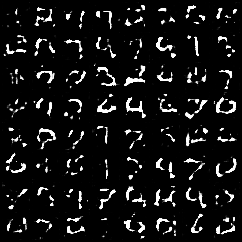

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use model to generate new sample

In [15]:
try:
    G.load_state_dict(torch.load(model_dir + '/lsgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/lsgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



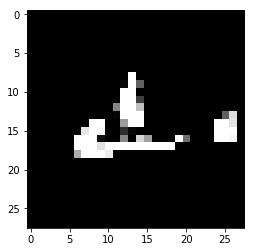

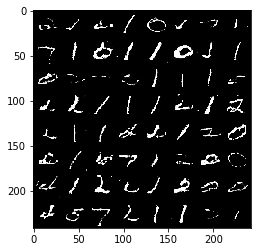

In [16]:
z = torch.randn(batch_size, z_dim)

if USE_CUDA:
    z = z.cuda()
    
fake_images = G(z)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(batch_size,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()